# 1 load package

In [1]:
import json
from collections import namedtuple, Counter

import numpy as np
import scanpy as sc
import pandas as pd
import squidpy as sq

## Image manipulation and geometry
from tifffile import imread
from skimage.io import imread as skimread

## Plotting imports
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize, to_hex, Colormap
from matplotlib.cm import ScalarMappable
from matplotlib.colorbar import ColorbarBase
from matplotlib.lines import Line2D
from matplotlib import rc_context

D:\anaconda\envs\xenium-publication-env\lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
D:\anaconda\envs\xenium-publication-env\lib\site-packages\numba\core\decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
### Functions for registration of Xenium to Visium data and associated analyis and visualization
## Visualization functions
from companion_functions import (
    hexlist_to_cmap,
    polygons_coords_to_patch_collection,
    plot_polygons,
    hex_corner_offset,
    polygon_corners,
    celltypes,
    celltypes,
    hex_codes,
    ctype_to_code_map,
    ctype_hex_map,
    ctype_cmap,
)

## Analysis functions
from companion_functions import (
    unique_encode,
    get_xenium_to_morphology_transform_from_xenium_morphology_image,
    get_xenium_capture_polygon_um,
    transform_coordinates,
    get_median_spot_to_spot_distance_from_centroids,
    generate_space_filling_visium_polygons,
    get_visium_capture_polygon,
    __OUTSIDE_VISIUM_CAPTURE_AREA_BARCODE__,
    bin_xenium_data_to_visium_spots,
    generate_anndata_matrix_from_transcript_assignments,
)

# 2 read in data

In [ ]:
import os
import re
import glob
import pandas as pd
import anndata as ad
from scipy.sparse import csr_matrix
from concurrent.futures import ThreadPoolExecutor 

input_dir = "result download from website/counts"
output_dir = "processed_h5ad"
os.makedirs(output_dir, exist_ok=True)

def parse_cell_identifier(cell_id):
   
    match = re.match(r"^([A-Za-z]+)(\d+)_(\d+)_(\d+)$", cell_id)
    return {
        'full_id': cell_id,
        'cell_type': match.group(1) if match else "Unknown",
        'cell_number': match.group(2) if match else -1,
        'coordinate_x': match.group(3) if match else -1,
        'expression': match.group(4) if match else -1
    }

def process_single_file(input_path, output_dir):
    try:
      
        base_name = os.path.basename(input_path)
        sample_id = re.search(r"adult1_(.*?)_DAPI", base_name).group(1)
        formatted_id = sample_id.replace("-", "_") 

   
        raw_df = pd.read_csv(input_path, sep='\t', index_col=0, engine='c')
        exp_matrix = raw_df.T.astype(pd.SparseDtype("float32", 0)) 

   
        cell_metadata = pd.DataFrame(
            [parse_cell_identifier(cell_id) for cell_id in exp_matrix.index],
            index=exp_matrix.index
        )
        cell_metadata["sample_id"] = formatted_id  

      
        adata = ad.AnnData(
            X=csr_matrix(exp_matrix.sparse.to_coo()),
            obs=cell_metadata,
            var=pd.DataFrame(index=raw_df.index),
            dtype='float32'
        )
        adata.uns["sample_id"] = formatted_id 

     
        output_path = os.path.join(output_dir, f"{formatted_id}_processed.h5ad")
        adata.write(output_path, compression="gzip")  
        
        print(f" {formatted_id} -> {output_path}")
        
    except Exception as e:
        print(f"{os.path.basename(input_path)}: {str(e)}")


file_pattern = "33422-2363-adult1_*_DAPI__7.5_mu_dilated_segmentation_counts.txt"
input_files = glob.glob(os.path.join(input_dir, file_pattern))


with ThreadPoolExecutor(max_workers=4) as executor:
    executor.map(process_single_file, input_files, [output_dir]*len(input_files))

In [ ]:
import os
import glob


h5ad_files = glob.glob(os.path.join("processed_h5ad", "*_processed.h5ad"))
print("")
for f in h5ad_files:
    print(f"- {os.path.basename(f)}")

In [4]:
import anndata as ad


adatas = []
for file_path in h5ad_files:
  
    sample_id = os.path.basename(file_path).split("_processed")[0]
    
 
    adata = ad.read_h5ad(file_path)
    

    adata.obs["sample_id"] = sample_id
    
    adatas.append(adata)

In [ ]:
combined_adata = ad.concat(
    adatas,
    axis=0,          
    join="inner",    
    label="sample",  
    keys=[os.path.basename(f).split("_processed")[0] for f in h5ad_files] 
)

print("")
print(combined_adata)

In [104]:
adata.write("combined_data_all_roi_new_processed.h5ad", compression="gzip")

In [7]:
adata=combined_adata

In [ ]:
# filter cell without enough trascript
sc.pp.filter_cells(adata, min_counts=5)
sc.pp.filter_genes(adata, min_cells=3)

# 3 process data

In [ ]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata,resolution = 0.4)

In [28]:
#set color
custom_palette = {
    "0": "#515151",
    "1": "#AB76AE",
    "2": "#ffa5aa",
    "3": "#FE664D",
    "4": "#ff002a",
    "5": "#00FFFF",
    "6": "#32a852",
    "7": "#e5e022",
    "8": "#565DFD",
    "9": "#4fa9ff",
    "10": "#F032E6",
    "11": "#32a88e",
    "12": "#FF1493",
    "13": "#FF1493",
    "14": "#9f50f9",
    "15": "#AB76AE",
    "16": "#999999",
    "17": "#515151",
    "18": "#FFD700",
    "19": "#00FFFF",
    "20": "#3694a8",
    "21": "#FF6347",
    "22": "#ffa5aa",
    "23": "#32a852",
    "24": "#a8329e",
    "25": "#3255a8",
    "26": "#a88232",
    "27": "#32a88e",
    "28": "#a83250",
}

In [ ]:
with rc_context({'figure.figsize': (5, 5)}):
     sc.pl.umap(combined_adata,color=[ "leiden",], size=10,palette=custom_palette,legend_loc="on data", save='umap_all.pdf')

In [ ]:
sample_to_donor_map = {
    'A1_3': 'FTM120',
    'A1_4': 'FTM120',
    'A2_1': 'FTM32',
    'A2_2': 'FTM32',
    'A2_3': 'FTM32',
    'A2_4': 'FTM32',
    'B2_1': 'FTM37',
    'B2_3': 'FTM37',
    'B2_4': 'FTM37',
    'C1_1': 'FTM31',
    'C2_1': 'FTM36',
    'C2_2': 'FTM36',
    'D1_1': 'FTM31',
    'D1_2': 'FTM31',
    'D1_3': 'FTM31',
    'D2_1': 'FTM44'
}
combined_adata.obs['Donors'] = combined_adata.obs['sample'].map(sample_to_donor_map)

In [ ]:
with rc_context({'figure.figsize': (5, 5)}):
     sc.pl.umap(combined_adata,color=[ "Donors",], size=1,legend_loc="on data", save='umap_donors.png')

In [ ]:
meta_data_resolve=combined_adata.obs
meta_data_resolve.to_excel("meta_data_resolve.xlsx", index=True)

In [ ]:
sc.tl.rank_genes_groups(combined_adata, "leiden", method="wilcoxon",pts=True)

In [63]:
rank_genes_df = sc.get.rank_genes_groups_df(adata, group=None)

In [ ]:
filtered_genes_df = rank_genes_df[
    (rank_genes_df['pvals_adj'] < 0.05) & 
    (rank_genes_df['pct_nz_group'] > 0.6)  
]

In [ ]:
filtered_genes_df.to_excel("DEG_resolve_filter.xlsx", index=False)

In [64]:
top_genes = []
groups = adata.obs['leiden'].cat.categories

for group in groups:
    top_genes.append(
        sc.get.rank_genes_groups_df(adata, group).head(5)
    )

top_genes_df = pd.concat(top_genes)
gene_names = top_genes_df['names'].unique()

In [ ]:
sc.tl.dendrogram(adata, groupby="leiden")
sc.pl.dendrogram(adata, "leiden")

In [ ]:
adata.layers["scaled"] = sc.pp.scale(adata, copy=True).X

In [ ]:
sc.pl.matrixplot(
    adata,
    gene_names,
    "leiden",
    colorbar_title="mean expression",
    dendrogram=True,
    layer="scaled",
    vmin=-2,
    vmax=2,
    cmap="RdBu_r",
    save='heatmap_all_roi_new_selected_zscore_res0.3.png'
)

# 4 mapping for cell cluster

In [ ]:
adata.obs["cell_id"]=adata.obs["full_id"]

In [ ]:
import os
import re
import glob
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from shapely.geometry import Polygon

def process_sample(adata, csv_path, output_dir="mapping"):
 
    try:
       
        filename = os.path.basename(csv_path)
        
      
        match = re.search(r'([A-Z]\d+-\d+)_DAPI', filename)
        if not match:
            raise ValueError(f" {filename}")
        sample_id = match.group(1) 
        
       
        df = pd.read_csv(csv_path, header=None, names=["cell_id", "x", "y"])
        
    
        geometries = []
        cell_ids = []
        for cell_id, group in df.groupby("cell_id"):
            coords = list(zip(group["x"], group["y"]))
            polygon = Polygon(coords)
            geometries.append(polygon)
            cell_ids.append(cell_id)
        
        xenium_cell_polygons = gpd.GeoDataFrame({'cell_id': cell_ids, 'geometry': geometries})

        xenium_cell_ids = set(xenium_cell_polygons["cell_id"].astype(str))
        adata_cell_ids = set(adata.obs["cell_id"].astype(str))
        common_cell_ids = xenium_cell_ids & adata_cell_ids
        print(f" {len(common_cell_ids)} common cell_id")

       
        valid_mask = (
            xenium_cell_polygons["cell_id"].astype(str).isin(common_cell_ids) &
            xenium_cell_polygons.geometry.is_valid &
            (xenium_cell_polygons.geometry.type == 'Polygon') &
            (xenium_cell_polygons.geometry.apply(lambda g: len(g.exterior.coords) >= 3))
        )
        valid_data = xenium_cell_polygons[valid_mask].merge(
            adata.obs[["leiden"]],
            how="left",
            left_on="cell_id",
            right_index=True
        )

        if valid_data.empty:
            raise ValueError("faild")

      
        fig = plt.figure(figsize=(13, 4))
        ax = plt.gca()
        fig.patch.set_facecolor('black')
        ax.set_facecolor('black')

       
        plot_polygons(
            [list(poly.exterior.coords) for poly in valid_data.geometry],
            ax=ax,
            array=valid_data["leiden"].map(ctype_to_code_map.get),
            edgecolor="none",
            linewidth=0,
            norm=Normalize(vmin=0, vmax=len(celltypes)),
            cmap=ctype_cmap,
        )

        
        for _, row in valid_data.iterrows():
            try:
                centroid = row.geometry.centroid
                ax.text(
                    centroid.x, centroid.y,
                    str(row["leiden"]),
                    fontsize=0.01,
                    ha='center', va='center',
                    color='white'
                )
            except Exception as e:
                print(f" {str(e)}")

       
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, f"{sample_id}_new.png")
        plt.savefig(output_path, dpi=900, bbox_inches='tight', pad_inches=0.1)
        plt.close()
        print(f" {output_path}")
        return True

    except Exception as e:
        print(f" {str(e)}")
        plt.close()
        return False


csv_files = glob.glob("result download from website/segment/33422-2363-adult1_*_DAPI__7.5_mu_dilated_segmentation_cell_polygons.csv")


success_count = 0
for idx, csv_file in enumerate(csv_files, 1):
    print(f"\n {idx}/{len(csv_files)}: {os.path.basename(csv_file)}")
    if process_sample(adata, csv_file):
        success_count += 1

print(f"\n {success_count} {len(csv_files)-success_count} ")

# 5 maping of gene

In [ ]:
import os
import re
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from shapely.geometry import Polygon
from scipy.sparse import issparse


TARGET_GENES = [
    "NR5A1", "STAR", "CYP11A1",  "CYP19A1", "HSD17B1", "HSD11B1",
    "ESR1", "ESR2", "PGR", "FSHR", "INHA", "INHBB", "BMPR1B", "BMPR2",
    "TGFBR1", "TGFBR3", "ACVR1B", "ACVR2A", "ACVR2B", "ID1", "ID3", "ID4",
    "DHH", "PTCH1", "PTCH2", "GLI1", "GLI2", "JAG1", "NOTCH1", "NOTCH2",
    "NOTCH3", "WNT6", "FZD6", "SFRP2"
]
SAMPLE_CSV_PATH = "result download from website/segment/33422-2363-adult1_B2-4_DAPI__7.5_mu_dilated_segmentation_cell_polygons.csv"
OUTPUT_DIR = "Gene_Expression_No_Legend"  
ASPECT_RATIO = (19, 17) 
DPI = 900              
CMAP = "plasma"        

missing_genes = [gene for gene in TARGET_GENES if gene not in adata.var_names]
existing_genes = [gene for gene in TARGET_GENES if gene in adata.var_names]

print(f" ({len(missing_genes)}):\n{missing_genes}\n")
print(f" ({len(existing_genes)}):\n{existing_genes}\n")


def plot_genes_without_legend(adata, csv_path, genes):
   
    try:
  
        df = pd.read_csv(csv_path, header=None, names=["cell_id", "x", "y"])
        df["cell_id"] = df["cell_id"].astype(str)  
        
     
        spatial_gdf = gpd.GeoDataFrame(
            [{'cell_id': cid, 'geometry': Polygon(zip(grp.x, grp.y))} 
             for cid, grp in df.groupby("cell_id")]
        ).set_index('cell_id')

       
        sample_cells = spatial_gdf.index.intersection(adata.obs['cell_id'].astype(str))
        adata_sample = adata[adata.obs['cell_id'].astype(str).isin(sample_cells)].copy()

        
        for gene in genes:
            
            if issparse(adata_sample.X):
                expr = pd.Series(
                    adata_sample[:, gene].X.toarray().flatten(),
                    index=adata_sample.obs['cell_id'].astype(str)
                )
            else:
                expr = pd.Series(
                    adata_sample[:, gene].X.flatten(),
                    index=adata_sample.obs['cell_id'].astype(str)
                )

            
            merged_gdf = spatial_gdf.join(expr.rename('expression'), how='inner')
            
            
            valid_gdf = merged_gdf[
                merged_gdf.geometry.is_valid & 
                (merged_gdf.geometry.type == 'Polygon') &
                (merged_gdf.geometry.apply(lambda g: len(g.exterior.coords) >= 3))
            ]
            
           
            expr_values = valid_gdf['expression']
            vmax = max(expr_values.quantile(0.99), 1e-5)  
            norm = Normalize(vmin=0, vmax=vmax)

           
            fig, ax = plt.subplots(figsize=ASPECT_RATIO, facecolor='black')
            ax.set_facecolor('black')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect("equal")

            
            for cid, row in valid_gdf.iterrows():
                poly = row['geometry']
                color = plt.get_cmap(CMAP)(norm(row['expression']))
                ax.fill(*poly.exterior.xy, color=color, linewidth=0)

            
            output_path = os.path.join(OUTPUT_DIR, f"{gene}_expression.png")
            plt.savefig(output_path, dpi=DPI, bbox_inches='tight')
            plt.close()
            print(f" {os.path.basename(output_path)}")

    except Exception as e:
        print(f" {str(e)}")
        plt.close() if 'plt' in locals() else None


if __name__ == "__main__":
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    plot_genes_without_legend(adata, SAMPLE_CSV_PATH, existing_genes)

In [16]:
from anndata import read_h5ad
adata=read_h5ad("processed_h5ad/C1_1_processed.h5ad")
adata.obs["cell_id"]=adata.obs["full_id"]

In [7]:
import os
import re
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from shapely.geometry import Polygon
from scipy.sparse import issparse

# ================== 配置参数 ==================
TARGET_GENES = ["IHH"]
SAMPLE_CSV_PATH = "result download from website/segment/33422-2363-adult1_C1-1_DAPI__7.5_mu_dilated_segmentation_cell_polygons.csv"
OUTPUT_DIR = "C1_1_1"  # 输出目录（建议新目录）
ASPECT_RATIO = (10.7,8.6)          # 图像比例
DPI = 900                        # 分辨率
CMAP = "plasma"                  # 颜色方案

# ================== 检查基因存在性 ==================
missing_genes = [gene for gene in TARGET_GENES if gene not in adata.var_names]
existing_genes = [gene for gene in TARGET_GENES if gene in adata.var_names]

print(f"未找到的基因 ({len(missing_genes)}):\n{missing_genes}\n")
print(f"即将绘制的基因 ({len(existing_genes)}):\n{existing_genes}\n")

# ================== 主函数（修改版）==================
def plot_genes_with_global_norm(adata, csv_path, genes):
    """绘制多基因表达图（全局颜色标准化）"""
    try:
        # 1. 读取空间数据并生成多边形（与原代码相同）
        df = pd.read_csv(csv_path, header=None, names=["cell_id", "x", "y"])
        df["cell_id"] = df["cell_id"].astype(str)
        
        spatial_gdf = gpd.GeoDataFrame(
            [{'cell_id': cid, 'geometry': Polygon(zip(grp.x, grp.y))} 
             for cid, grp in df.groupby("cell_id")]
        ).set_index('cell_id')

        # 2. 提取样本对应的adata子集（与原代码相同）
        sample_cells = spatial_gdf.index.intersection(adata.obs['cell_id'].astype(str))
        adata_sample = adata[adata.obs['cell_id'].astype(str).isin(sample_cells)].copy()

        # 3. 遍历每个基因绘图（关键修改部分）
        for gene in genes:
            # 全局计算颜色范围（跨所有样本）
            if issparse(adata.X):
                global_expr = adata[:, gene].X.toarray().flatten()
            else:
                global_expr = adata[:, gene].X.flatten()
            
            # 计算全局vmax
            global_vmax = max(np.quantile(global_expr, 0.99), 1e-5)
            norm = Normalize(vmin=0, vmax=global_vmax)

            # 提取当前样本的表达数据（与原代码相同）
            if issparse(adata_sample.X):
                expr = pd.Series(
                    adata_sample[:, gene].X.toarray().flatten(),
                    index=adata_sample.obs['cell_id'].astype(str)
                )
            else:
                expr = pd.Series(
                    adata_sample[:, gene].X.flatten(),
                    index=adata_sample.obs['cell_id'].astype(str)
                )

            # 合并空间与表达数据（与原代码相同）
            merged_gdf = spatial_gdf.join(expr.rename('expression'), how='inner')
            valid_gdf = merged_gdf[
                merged_gdf.geometry.is_valid & 
                (merged_gdf.geometry.type == 'Polygon') &
                (merged_gdf.geometry.apply(lambda g: len(g.exterior.coords) >= 3))
            ]

            # 创建画布（与原代码相同）
            fig, ax = plt.subplots(figsize=ASPECT_RATIO, facecolor='black')
            ax.set_facecolor('black')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect("equal")

            # 绘制多边形（使用全局norm）
            for cid, row in valid_gdf.iterrows():
                poly = row['geometry']
                color = plt.get_cmap(CMAP)(norm(row['expression']))  # 关键点：使用全局norm
                ax.fill(*poly.exterior.xy, color=color, linewidth=0)

            # 保存图像
            output_path = os.path.join(OUTPUT_DIR, f"{gene}_expression.png")
            plt.savefig(output_path, dpi=DPI, bbox_inches='tight')
            plt.close()
            print(f"生成: {os.path.basename(output_path)}")

    except Exception as e:
        print(f"严重错误: {str(e)}")
        plt.close() if 'plt' in locals() else None

# ================== 执行代码 ==================
if __name__ == "__main__":
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    plot_genes_with_global_norm(adata, SAMPLE_CSV_PATH, existing_genes)

未找到的基因 (0):
[]

即将绘制的基因 (1):
['IHH']

生成: IHH_expression.png


In [18]:
import os
import re
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from shapely.geometry import Polygon
from scipy.sparse import issparse
from matplotlib.cm import ScalarMappable  # 导入 ScalarMappable

# ================== 配置参数 ==================
TARGET_GENES = ["IHH"]
SAMPLE_CSV_PATH = "result download from website/segment/33422-2363-adult1_C1-1_DAPI__7.5_mu_dilated_segmentation_cell_polygons.csv"
OUTPUT_DIR = "C1_1_1"  # 输出目录（建议新目录）
ASPECT_RATIO = (10.7,8.6)          # 图像比例
DPI = 900                       # 分辨率
CMAP = "plasma"                 # 颜色方案

# ================== 检查基因存在性 ==================
missing_genes = [gene for gene in TARGET_GENES if gene not in adata.var_names]
existing_genes = [gene for gene in TARGET_GENES if gene in adata.var_names]

print(f"未找到的基因 ({len(missing_genes)}):\n{missing_genes}\n")
print(f"即将绘制的基因 ({len(existing_genes)}):\n{existing_genes}\n")

# ================== 主函数（修改版）==================
def plot_genes_with_global_norm(adata, csv_path, genes):
    """绘制多基因表达图（全局颜色标准化）"""
    try:
        # 1. 读取空间数据并生成多边形（与原代码相同）
        df = pd.read_csv(csv_path, header=None, names=["cell_id", "x", "y"])
        df["cell_id"] = df["cell_id"].astype(str)

        spatial_gdf = gpd.GeoDataFrame(
            [{'cell_id': cid, 'geometry': Polygon(zip(grp.x, grp.y))}
             for cid, grp in df.groupby("cell_id")]
        ).set_index('cell_id')

        # 2. 提取样本对应的adata子集（与原代码相同）
        sample_cells = spatial_gdf.index.intersection(adata.obs['cell_id'].astype(str))
        adata_sample = adata[adata.obs['cell_id'].astype(str).isin(sample_cells)].copy()

        # 3. 遍历每个基因绘图（关键修改部分）
        for gene in genes:
            # 全局计算颜色范围（跨所有样本）
            if issparse(adata.X):
                global_expr = adata[:, gene].X.toarray().flatten()
            else:
                global_expr = adata[:, gene].X.flatten()

            # 计算全局vmax
            global_vmax = max(np.quantile(global_expr, 0.99), 1e-5)
            norm = Normalize(vmin=0, vmax=global_vmax)
            cmap = plt.get_cmap(CMAP)

            # 提取当前样本的表达数据（与原代码相同）
            if issparse(adata_sample.X):
                expr = pd.Series(
                    adata_sample[:, gene].X.toarray().flatten(),
                    index=adata_sample.obs['cell_id'].astype(str)
                )
            else:
                expr = pd.Series(
                    adata_sample[:, gene].X.flatten(),
                    index=adata_sample.obs['cell_id'].astype(str)
                )

            # 合并空间与表达数据（与原代码相同）
            merged_gdf = spatial_gdf.join(expr.rename('expression'), how='inner')
            valid_gdf = merged_gdf[
                merged_gdf.geometry.is_valid &
                (merged_gdf.geometry.type == 'Polygon') &
                (merged_gdf.geometry.apply(lambda g: len(g.exterior.coords) >= 3))
            ]

            # 创建画布（修改背景颜色为白色）
            fig, ax = plt.subplots(figsize=ASPECT_RATIO, facecolor='white')
            ax.set_facecolor('white')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect("equal")

            # 绘制多边形（使用全局norm）
            for cid, row in valid_gdf.iterrows():
                poly = row['geometry']
                color = cmap(norm(row['expression']))  # 关键点：使用全局norm
                ax.fill(*poly.exterior.xy, color=color, linewidth=0)

            # 添加颜色图例
            sm = ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])  # for older matplotlib versions
            cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04) # 调整图例大小和位置
            cbar.set_label(f"{gene} Expression", color='black') # 设置图例标签颜色
            cbar.ax.tick_params(labelcolor='black') # 设置图例刻度标签颜色

            # 保存图像
            output_path = os.path.join(OUTPUT_DIR, f"{gene}_expression.png")
            plt.savefig(output_path, dpi=DPI, bbox_inches='tight')
            plt.close()
            print(f"生成: {os.path.basename(output_path)}")

    except Exception as e:
        print(f"严重错误: {str(e)}")
        plt.close() if 'plt' in locals() else None

# ================== 执行代码 ==================
if __name__ == "__main__":
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    plot_genes_with_global_norm(adata, SAMPLE_CSV_PATH, existing_genes)

未找到的基因 (0):
[]

即将绘制的基因 (1):
['IHH']

生成: IHH_expression.png


In [19]:
import os
import re
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from shapely.geometry import Polygon
from scipy.sparse import issparse
from matplotlib.cm import ScalarMappable  # 导入 ScalarMappable

# ================== 配置参数 ==================
TARGET_GENES = ["IHH"]
SAMPLE_CSV_PATH = "result download from website/segment/33422-2363-adult1_C1-1_DAPI__7.5_mu_dilated_segmentation_cell_polygons.csv"
OUTPUT_DIR = "C1_1_1"  # 输出目录（建议新目录）
ASPECT_RATIO = (10.7,8.6)          # 图像比例
DPI = 900                       # 分辨率
CMAP = "plasma"                 # 颜色方案

# ================== 检查基因存在性 ==================
missing_genes = [gene for gene in TARGET_GENES if gene not in adata.var_names]
existing_genes = [gene for gene in TARGET_GENES if gene in adata.var_names]

print(f"未找到的基因 ({len(missing_genes)}):\n{missing_genes}\n")
print(f"即将绘制的基因 ({len(existing_genes)}):\n{existing_genes}\n")

# ================== 主函数（修改版）==================
def plot_genes_with_global_norm(adata, csv_path, genes):
    """绘制多基因表达图（全局颜色标准化）"""
    try:
        # 1. 读取空间数据并生成多边形（与原代码相同）
        df = pd.read_csv(csv_path, header=None, names=["cell_id", "x", "y"])
        df["cell_id"] = df["cell_id"].astype(str)

        spatial_gdf = gpd.GeoDataFrame(
            [{'cell_id': cid, 'geometry': Polygon(zip(grp.x, grp.y))}
             for cid, grp in df.groupby("cell_id")]
        ).set_index('cell_id')

        # 2. 提取样本对应的adata子集（与原代码相同）
        sample_cells = spatial_gdf.index.intersection(adata.obs['cell_id'].astype(str))
        adata_sample = adata[adata.obs['cell_id'].astype(str).isin(sample_cells)].copy()

        # 3. 遍历每个基因绘图（关键修改部分）
        for gene in genes:
            # 全局计算颜色范围（跨所有样本）
            if issparse(adata.X):
                global_expr = adata[:, gene].X.toarray().flatten()
            else:
                global_expr = adata[:, gene].X.flatten()

            # 计算全局vmax
            global_vmax = max(np.quantile(global_expr, 0.99), 1e-5)
            norm = Normalize(vmin=0, vmax=global_vmax)
            cmap = plt.get_cmap(CMAP)

            # 提取当前样本的表达数据（与原代码相同）
            if issparse(adata_sample.X):
                expr = pd.Series(
                    adata_sample[:, gene].X.toarray().flatten(),
                    index=adata_sample.obs['cell_id'].astype(str)
                )
            else:
                expr = pd.Series(
                    adata_sample[:, gene].X.flatten(),
                    index=adata_sample.obs['cell_id'].astype(str)
                )

            # 合并空间与表达数据（与原代码相同）
            merged_gdf = spatial_gdf.join(expr.rename('expression'), how='inner')
            valid_gdf = merged_gdf[
                merged_gdf.geometry.is_valid &
                (merged_gdf.geometry.type == 'Polygon') &
                (merged_gdf.geometry.apply(lambda g: len(g.exterior.coords) >= 3))
            ]

            # 创建画布（修改背景颜色为白色）
            fig, ax = plt.subplots(figsize=ASPECT_RATIO, facecolor='white')
            ax.set_facecolor('white')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect("equal")

            # 绘制多边形（使用全局norm）
            for cid, row in valid_gdf.iterrows():
                poly = row['geometry']
                color = cmap(norm(row['expression']))  # 关键点：使用全局norm
                ax.fill(*poly.exterior.xy, color=color, linewidth=0)

            # 保存主图
            output_path_main = os.path.join(OUTPUT_DIR, f"{gene}_expression.png")
            plt.savefig(output_path_main, dpi=DPI, bbox_inches='tight')
            plt.close(fig) # 关闭主图

            # 创建新的 Figure 和 Axes 用于保存图例
            fig_legend = plt.figure(figsize=(1, 6)) # 设置图例的尺寸
            ax_legend = fig_legend.add_axes([0.1, 0.1, 0.2, 0.8]) # [左, 下, 宽, 高] 调整图例位置和大小

            # 添加颜色图例到新的 Axes
            sm = ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])  # for older matplotlib versions
            cbar = plt.colorbar(sm, cax=ax_legend)
            cbar.set_label(f"{gene} Expression", color='black')
            cbar.ax.tick_params(labelcolor='black')

            # 保存图例为 PDF
            output_path_legend = os.path.join(OUTPUT_DIR, f"{gene}_legend.pdf")
            plt.savefig(output_path_legend, bbox_inches='tight', format='pdf')
            plt.close(fig_legend) # 关闭图例的 Figure

            print(f"生成: {os.path.basename(output_path_main)}")
            print(f"生成图例: {os.path.basename(output_path_legend)}")

    except Exception as e:
        print(f"严重错误: {str(e)}")
        plt.close() if 'plt' in locals() else None
        plt.close() if 'fig_legend' in locals() else None

# ================== 执行代码 ==================
if __name__ == "__main__":
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    plot_genes_with_global_norm(adata, SAMPLE_CSV_PATH, existing_genes)

未找到的基因 (0):
[]

即将绘制的基因 (1):
['IHH']

生成: IHH_expression.png
生成图例: IHH_legend.pdf


In [9]:
import os
import re
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from shapely.geometry import Polygon
from scipy.sparse import issparse

# ================== 配置参数 ==================
TARGET_GENES = ["IHH"]
SAMPLE_CSV_PATH = "result download from website/segment/33422-2363-adult1_A1-4_DAPI__7.5_mu_dilated_segmentation_cell_polygons.csv"
OUTPUT_DIR = "A1_4"  # 输出目录（建议新目录）
ASPECT_RATIO = (12.8,4.3)          # 图像比例
DPI = 900                        # 分辨率
CMAP = "plasma"                  # 颜色方案

# ================== 检查基因存在性 ==================
missing_genes = [gene for gene in TARGET_GENES if gene not in adata.var_names]
existing_genes = [gene for gene in TARGET_GENES if gene in adata.var_names]

print(f"未找到的基因 ({len(missing_genes)}):\n{missing_genes}\n")
print(f"即将绘制的基因 ({len(existing_genes)}):\n{existing_genes}\n")

# ================== 主函数（修改版）==================
def plot_genes_with_global_norm(adata, csv_path, genes):
    """绘制多基因表达图（全局颜色标准化）"""
    try:
        # 1. 读取空间数据并生成多边形（与原代码相同）
        df = pd.read_csv(csv_path, header=None, names=["cell_id", "x", "y"])
        df["cell_id"] = df["cell_id"].astype(str)
        
        spatial_gdf = gpd.GeoDataFrame(
            [{'cell_id': cid, 'geometry': Polygon(zip(grp.x, grp.y))} 
             for cid, grp in df.groupby("cell_id")]
        ).set_index('cell_id')

        # 2. 提取样本对应的adata子集（与原代码相同）
        sample_cells = spatial_gdf.index.intersection(adata.obs['cell_id'].astype(str))
        adata_sample = adata[adata.obs['cell_id'].astype(str).isin(sample_cells)].copy()

        # 3. 遍历每个基因绘图（关键修改部分）
        for gene in genes:
            # 全局计算颜色范围（跨所有样本）
            if issparse(adata.X):
                global_expr = adata[:, gene].X.toarray().flatten()
            else:
                global_expr = adata[:, gene].X.flatten()
            
            # 计算全局vmax
            global_vmax = max(np.quantile(global_expr, 0.99), 1e-5)
            norm = Normalize(vmin=0, vmax=global_vmax)

            # 提取当前样本的表达数据（与原代码相同）
            if issparse(adata_sample.X):
                expr = pd.Series(
                    adata_sample[:, gene].X.toarray().flatten(),
                    index=adata_sample.obs['cell_id'].astype(str)
                )
            else:
                expr = pd.Series(
                    adata_sample[:, gene].X.flatten(),
                    index=adata_sample.obs['cell_id'].astype(str)
                )

            # 合并空间与表达数据（与原代码相同）
            merged_gdf = spatial_gdf.join(expr.rename('expression'), how='inner')
            valid_gdf = merged_gdf[
                merged_gdf.geometry.is_valid & 
                (merged_gdf.geometry.type == 'Polygon') &
                (merged_gdf.geometry.apply(lambda g: len(g.exterior.coords) >= 3))
            ]

            # 创建画布（与原代码相同）
            fig, ax = plt.subplots(figsize=ASPECT_RATIO, facecolor='black')
            ax.set_facecolor('black')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect("equal")

            # 绘制多边形（使用全局norm）
            for cid, row in valid_gdf.iterrows():
                poly = row['geometry']
                color = plt.get_cmap(CMAP)(norm(row['expression']))  # 关键点：使用全局norm
                ax.fill(*poly.exterior.xy, color=color, linewidth=0)

            # 保存图像
            output_path = os.path.join(OUTPUT_DIR, f"{gene}_expression.png")
            plt.savefig(output_path, dpi=DPI, bbox_inches='tight')
            plt.close()
            print(f"生成: {os.path.basename(output_path)}")

    except Exception as e:
        print(f"严重错误: {str(e)}")
        plt.close() if 'plt' in locals() else None

# ================== 执行代码 ==================
if __name__ == "__main__":
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    plot_genes_with_global_norm(adata, SAMPLE_CSV_PATH, existing_genes)

未找到的基因 (0):
[]

即将绘制的基因 (1):
['IHH']

生成: IHH_expression.png


In [11]:
import os
import re
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from shapely.geometry import Polygon
from scipy.sparse import issparse

# ================== 配置参数 ==================
TARGET_GENES =  ["IHH"]
SAMPLE_CSV_PATH = "result download from website/segment/33422-2363-adult1_C2-2_DAPI__7.5_mu_dilated_segmentation_cell_polygons.csv"
OUTPUT_DIR = "C2_2"  # 输出目录（建议新目录）
ASPECT_RATIO = (20,20)          # 图像比例
DPI = 900                        # 分辨率
CMAP = "plasma"                  # 颜色方案

# ================== 检查基因存在性 ==================
missing_genes = [gene for gene in TARGET_GENES if gene not in adata.var_names]
existing_genes = [gene for gene in TARGET_GENES if gene in adata.var_names]

print(f"未找到的基因 ({len(missing_genes)}):\n{missing_genes}\n")
print(f"即将绘制的基因 ({len(existing_genes)}):\n{existing_genes}\n")

# ================== 主函数（修改版）==================
def plot_genes_with_global_norm(adata, csv_path, genes):
    """绘制多基因表达图（全局颜色标准化）"""
    try:
        # 1. 读取空间数据并生成多边形（与原代码相同）
        df = pd.read_csv(csv_path, header=None, names=["cell_id", "x", "y"])
        df["cell_id"] = df["cell_id"].astype(str)
        
        spatial_gdf = gpd.GeoDataFrame(
            [{'cell_id': cid, 'geometry': Polygon(zip(grp.x, grp.y))} 
             for cid, grp in df.groupby("cell_id")]
        ).set_index('cell_id')

        # 2. 提取样本对应的adata子集（与原代码相同）
        sample_cells = spatial_gdf.index.intersection(adata.obs['cell_id'].astype(str))
        adata_sample = adata[adata.obs['cell_id'].astype(str).isin(sample_cells)].copy()

        # 3. 遍历每个基因绘图（关键修改部分）
        for gene in genes:
            # 全局计算颜色范围（跨所有样本）
            if issparse(adata.X):
                global_expr = adata[:, gene].X.toarray().flatten()
            else:
                global_expr = adata[:, gene].X.flatten()
            
            # 计算全局vmax
            global_vmax = max(np.quantile(global_expr, 0.99), 1e-5)
            norm = Normalize(vmin=0, vmax=global_vmax)

            # 提取当前样本的表达数据（与原代码相同）
            if issparse(adata_sample.X):
                expr = pd.Series(
                    adata_sample[:, gene].X.toarray().flatten(),
                    index=adata_sample.obs['cell_id'].astype(str)
                )
            else:
                expr = pd.Series(
                    adata_sample[:, gene].X.flatten(),
                    index=adata_sample.obs['cell_id'].astype(str)
                )

            # 合并空间与表达数据（与原代码相同）
            merged_gdf = spatial_gdf.join(expr.rename('expression'), how='inner')
            valid_gdf = merged_gdf[
                merged_gdf.geometry.is_valid & 
                (merged_gdf.geometry.type == 'Polygon') &
                (merged_gdf.geometry.apply(lambda g: len(g.exterior.coords) >= 3))
            ]

            # 创建画布（与原代码相同）
            fig, ax = plt.subplots(figsize=ASPECT_RATIO, facecolor='black')
            ax.set_facecolor('black')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect("equal")

            # 绘制多边形（使用全局norm）
            for cid, row in valid_gdf.iterrows():
                poly = row['geometry']
                color = plt.get_cmap(CMAP)(norm(row['expression']))  # 关键点：使用全局norm
                ax.fill(*poly.exterior.xy, color=color, linewidth=0)

            # 保存图像
            output_path = os.path.join(OUTPUT_DIR, f"{gene}_expression.png")
            plt.savefig(output_path, dpi=DPI, bbox_inches='tight')
            plt.close()
            print(f"生成: {os.path.basename(output_path)}")

    except Exception as e:
        print(f"严重错误: {str(e)}")
        plt.close() if 'plt' in locals() else None

# ================== 执行代码 ==================
if __name__ == "__main__":
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    plot_genes_with_global_norm(adata, SAMPLE_CSV_PATH, existing_genes)

未找到的基因 (0):
[]

即将绘制的基因 (1):
['IHH']

生成: IHH_expression.png


In [15]:
import os
import re
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from shapely.geometry import Polygon
from scipy.sparse import issparse

# ================== 配置参数 ==================
TARGET_GENES = ["IHH"]
SAMPLE_CSV_PATH = "result download from website/segment/33422-2363-adult1_A1-3_DAPI__7.5_mu_dilated_segmentation_cell_polygons.csv"
OUTPUT_DIR = "A1_3"  # 输出目录（建议新目录）
ASPECT_RATIO = (9,9)          # 图像比例
DPI = 900                        # 分辨率
CMAP = "plasma"                  # 颜色方案

# ================== 检查基因存在性 ==================
missing_genes = [gene for gene in TARGET_GENES if gene not in adata.var_names]
existing_genes = [gene for gene in TARGET_GENES if gene in adata.var_names]

print(f"未找到的基因 ({len(missing_genes)}):\n{missing_genes}\n")
print(f"即将绘制的基因 ({len(existing_genes)}):\n{existing_genes}\n")

# ================== 主函数（修改版）==================
def plot_genes_with_global_norm(adata, csv_path, genes):
    """绘制多基因表达图（全局颜色标准化）"""
    try:
        # 1. 读取空间数据并生成多边形（与原代码相同）
        df = pd.read_csv(csv_path, header=None, names=["cell_id", "x", "y"])
        df["cell_id"] = df["cell_id"].astype(str)
        
        spatial_gdf = gpd.GeoDataFrame(
            [{'cell_id': cid, 'geometry': Polygon(zip(grp.x, grp.y))} 
             for cid, grp in df.groupby("cell_id")]
        ).set_index('cell_id')

        # 2. 提取样本对应的adata子集（与原代码相同）
        sample_cells = spatial_gdf.index.intersection(adata.obs['cell_id'].astype(str))
        adata_sample = adata[adata.obs['cell_id'].astype(str).isin(sample_cells)].copy()

        # 3. 遍历每个基因绘图（关键修改部分）
        for gene in genes:
            # 全局计算颜色范围（跨所有样本）
            if issparse(adata.X):
                global_expr = adata[:, gene].X.toarray().flatten()
            else:
                global_expr = adata[:, gene].X.flatten()
            
            # 计算全局vmax
            global_vmax = max(np.quantile(global_expr, 0.99), 1e-5)
            norm = Normalize(vmin=0, vmax=global_vmax)

            # 提取当前样本的表达数据（与原代码相同）
            if issparse(adata_sample.X):
                expr = pd.Series(
                    adata_sample[:, gene].X.toarray().flatten(),
                    index=adata_sample.obs['cell_id'].astype(str)
                )
            else:
                expr = pd.Series(
                    adata_sample[:, gene].X.flatten(),
                    index=adata_sample.obs['cell_id'].astype(str)
                )

            # 合并空间与表达数据（与原代码相同）
            merged_gdf = spatial_gdf.join(expr.rename('expression'), how='inner')
            valid_gdf = merged_gdf[
                merged_gdf.geometry.is_valid & 
                (merged_gdf.geometry.type == 'Polygon') &
                (merged_gdf.geometry.apply(lambda g: len(g.exterior.coords) >= 3))
            ]

            # 创建画布（与原代码相同）
            fig, ax = plt.subplots(figsize=ASPECT_RATIO, facecolor='black')
            ax.set_facecolor('black')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect("equal")

            # 绘制多边形（使用全局norm）
            for cid, row in valid_gdf.iterrows():
                poly = row['geometry']
                color = plt.get_cmap(CMAP)(norm(row['expression']))  # 关键点：使用全局norm
                ax.fill(*poly.exterior.xy, color=color, linewidth=0)

            # 保存图像
            output_path = os.path.join(OUTPUT_DIR, f"{gene}_expression.png")
            plt.savefig(output_path, dpi=DPI, bbox_inches='tight')
            plt.close()
            print(f"生成: {os.path.basename(output_path)}")

    except Exception as e:
        print(f"严重错误: {str(e)}")
        plt.close() if 'plt' in locals() else None

# ================== 执行代码 ==================
if __name__ == "__main__":
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    plot_genes_with_global_norm(adata, SAMPLE_CSV_PATH, existing_genes)

未找到的基因 (1):
['IHH']

即将绘制的基因 (0):
[]



In [ ]:
combined_data_all_roi_new_selected_processed_res1.h5ad"

In [7]:
from anndata import read_h5ad
combined_adata=read_h5ad("combined_data_all_roi_new_processed.h5ad")

D:\anaconda\envs\xenium-publication-env\lib\site-packages\anndata\_core\anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [8]:
combined_adata.obs

,full_id,cell_type,cell_number,coordinate_x,expression,sample_id,sample,leiden,cell_id
Cell1_2180_16,Cell1_2180_16,Cell,1,2180,16,A1_3,A1_3,1,Cell1_2180_16
Cell2_2297_13,Cell2_2297_13,Cell,2,2297,13,A1_3,A1_3,1,Cell2_2297_13
Cell3_2340_2,Cell3_2340_2,Cell,3,2340,2,A1_3,A1_3,1,Cell3_2340_2
Cell4_2433_8,Cell4_2433_8,Cell,4,2433,8,A1_3,A1_3,1,Cell4_2433_8
Cell5_2543_3,Cell5_2543_3,Cell,5,2543,3,A1_3,A1_3,1,Cell5_2543_3
...,...,...,...,...,...,...,...,...,...
Cell9330_7186_10693,Cell9330_7186_10693,Cell,9330,7186,10693,D2_1,D2_1,3,Cell9330_7186_10693
Cell9331_9416_10684,Cell9331_9416_10684,Cell,9331,9416,10684,D2_1,D2_1,2,Cell9331_9416_10684
Cell9332_2161_10668,Cell9332_2161_10668,Cell,9332,2161,10668,D2_1,D2_1,2,Cell9332_2161_10668
Cell9333_2532_10686,Cell9333_2532_10686,Cell,9333,2532,10686,D2_1,D2_1,2,Cell9333_2532_10686


In [9]:
combined_adata.obs["leiden"].value_counts()

leiden
0     64719
1     61383
2     28910
3     23115
4     15913
5     15196
6     14719
7     11576
8      8413
9      2728
10     2632
11     1303
12      814
Name: count, dtype: int64

In [10]:
combined_adata.obs["sample"].value_counts()

sample
D1_1    34889
A2_2    26306
B2_1    24795
D1_2    24244
C2_2    23723
B2_4    21572
A2_3    16332
D1_3    14816
A2_1    12798
A1_3    11208
C1_1     9444
D2_1     9331
A1_4     9043
B2_3     6323
A2_4     3832
C2_1     2765
Name: count, dtype: int64

In [13]:
#sc.tl.rank_genes_groups(combined_adata, "leiden", method="wilcoxon")
rank_genes_df = sc.get.rank_genes_groups_df(combined_adata, group=None)
rank_genes_df

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,MYH11,213.796295,2.025504,0.000000e+00,0.000000e+00
1,0,NCAM1,174.460861,1.451739,0.000000e+00,0.000000e+00
2,0,CLDN11,160.236740,1.349487,0.000000e+00,0.000000e+00
3,0,DCN,153.185547,1.480142,0.000000e+00,0.000000e+00
4,0,LTBP1,135.543106,1.269664,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...
1022,12,FN1,-15.946617,-0.571678,3.007513e-57,9.503742e-57
1023,12,SNAI2,-15.966904,-2.050939,2.173094e-57,7.153100e-57
1024,12,THBS1,-17.928894,-2.334852,7.016194e-72,2.639425e-71
1025,12,CLDN11,-22.512823,-1.832659,3.108349e-112,1.292419e-111


In [16]:
sc.tl.rank_genes_groups(combined_adata, "leiden", method="wilcoxon",pts=True)

D:\anaconda\envs\xenium-publication-env\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [17]:
rank_genes_df = sc.get.rank_genes_groups_df(combined_adata, group=None)
rank_genes_df

,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
0,0,MYH11,213.796295,2.025504,0.000000e+00,0.000000e+00,0.946152,0.577975
1,0,NCAM1,174.460861,1.451739,0.000000e+00,0.000000e+00,0.870486,0.565741
2,0,CLDN11,160.236740,1.349487,0.000000e+00,0.000000e+00,0.949597,0.703410
3,0,DCN,153.185547,1.480142,0.000000e+00,0.000000e+00,0.990559,0.728043
4,0,LTBP1,135.543106,1.269664,0.000000e+00,0.000000e+00,0.706470,0.447360
...,...,...,...,...,...,...,...,...
1022,12,FN1,-15.946617,-0.571678,3.007513e-57,9.503742e-57,0.936118,0.874728
1023,12,SNAI2,-15.966904,-2.050939,2.173094e-57,7.153100e-57,0.227273,0.493901
1024,12,THBS1,-17.928894,-2.334852,7.016194e-72,2.639425e-71,0.405405,0.586711
1025,12,CLDN11,-22.512823,-1.832659,3.108349e-112,1.292419e-111,0.657248,0.767137


In [18]:
filtered_genes_df = rank_genes_df[
    (rank_genes_df['pvals_adj'] < 0.05) & # 条件1：pvals_adj 小于 0.05
    (rank_genes_df['pct_nz_group'] > 0.6)   # 条件2：pct_nz_group 大于 0.6
]

In [19]:
filtered_genes_df

,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
0,0,MYH11,213.796295,2.025504,0.000000e+00,0.000000e+00,0.946152,0.577975
1,0,NCAM1,174.460861,1.451739,0.000000e+00,0.000000e+00,0.870486,0.565741
2,0,CLDN11,160.236740,1.349487,0.000000e+00,0.000000e+00,0.949597,0.703410
3,0,DCN,153.185547,1.480142,0.000000e+00,0.000000e+00,0.990559,0.728043
4,0,LTBP1,135.543106,1.269664,0.000000e+00,0.000000e+00,0.706470,0.447360
...,...,...,...,...,...,...,...,...
981,12,APOE,5.199439,0.177195,1.998912e-07,3.036808e-07,0.841523,0.609592
1011,12,ITGB1,-5.542020,-0.062847,2.990015e-08,4.820637e-08,0.990172,0.901192
1015,12,MYH11,-8.350861,-0.897330,6.776710e-17,1.372718e-16,0.760442,0.672463
1022,12,FN1,-15.946617,-0.571678,3.007513e-57,9.503742e-57,0.936118,0.874728


In [22]:
rank_genes_df.to_excel("DEG_resolve.xlsx", index=False)

In [23]:
filtered_genes_df.to_excel("DEG_resolve_filter.xlsx", index=False)

In [24]:
sample_to_donor_map = {
    'A1_3': 'FTM120',
    'A1_4': 'FTM120',
    'A2_1': 'FTM32',
    'A2_2': 'FTM32',
    'A2_3': 'FTM32',
    'A2_4': 'FTM32',
    'B2_1': 'FTM37',
    'B2_3': 'FTM37',
    'B2_4': 'FTM37',
    'C1_1': 'FTM31',
    'C2_1': 'FTM36',
    'C2_2': 'FTM36',
    'D1_1': 'FTM31',
    'D1_2': 'FTM31',
    'D1_3': 'FTM31',
    'D2_1': 'FTM44'
    # 确保这个字典包含了 combined_adata.obs['sample'] 中所有可能的值
    # 如果有 sample 值不在这个映射中，它们对应的 Donors 值将是 NaN
}


In [25]:
 combined_adata.obs['Donors'] = combined_adata.obs['sample'].map(sample_to_donor_map)

In [26]:
if combined_adata.obs['Donors'].isnull().any():
        print("\n注意: 'Donors' 列中存在 NaN 值，意味着某些 'sample' 值没有对应的 Donors 映射。")
        print("未映射的 'sample' 值 (如果存在):")
        unmapped_samples = combined_adata.obs.loc[combined_adata.obs['Donors'].isnull(), 'sample'].unique()
        print(unmapped_samples)

In [27]:
combined_adata.obs["Donors"].value_counts()

Donors
FTM31     83393
FTM32     59268
FTM37     52690
FTM36     26488
FTM120    20251
FTM44      9331
Name: count, dtype: int64

D:\anaconda\envs\xenium-publication-env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
D:\anaconda\envs\xenium-publication-env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
D:\anaconda\envs\xenium-publication-env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


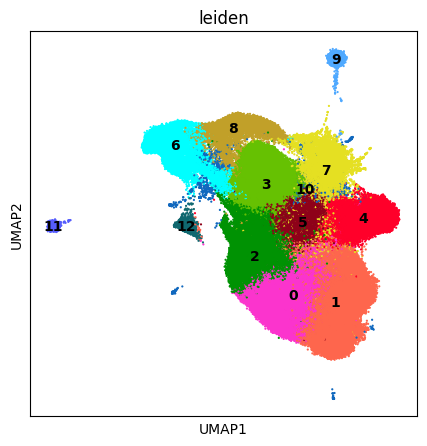

In [30]:
with rc_context({'figure.figsize': (5, 5)}):
     sc.pl.umap(combined_adata,color=[ "leiden",], size=10,palette=custom_palette,legend_loc="on data")

D:\anaconda\envs\xenium-publication-env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
D:\anaconda\envs\xenium-publication-env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
D:\anaconda\envs\xenium-publication-env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


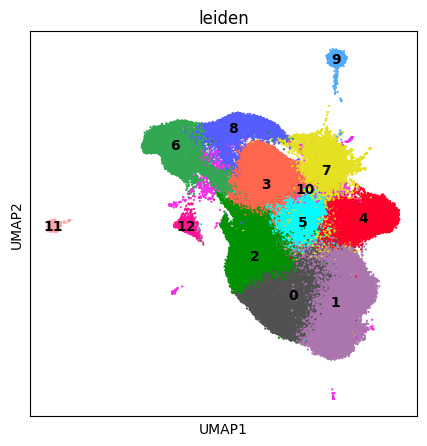

In [32]:
with rc_context({'figure.figsize': (5, 5)}):
     sc.pl.umap(combined_adata,color=[ "leiden",], size=10,palette=custom_palette,legend_loc="on data", save='umap_all.pdf')

D:\anaconda\envs\xenium-publication-env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
D:\anaconda\envs\xenium-publication-env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
D:\anaconda\envs\xenium-publication-env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


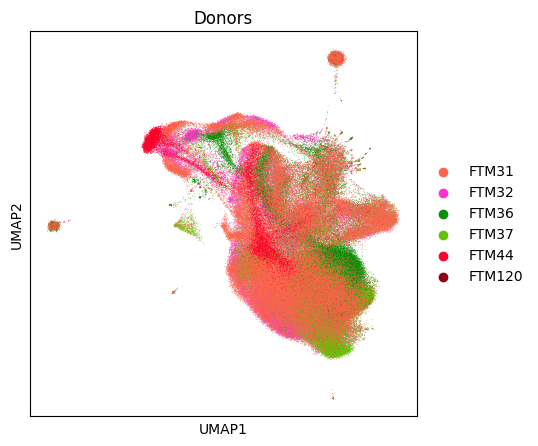

In [47]:
with rc_context({'figure.figsize': (5, 5)}):
     sc.pl.umap(combined_adata,color=[ "Donors",], size=1,palette=custom_palette)

In [46]:
custom_palette = {
    "FTM32": "#fb34cd",
    "FTM31": "#FE664D",
    "FTM36": "#009203",
    "FTM37": "#66c102",
    "FTM44": "#ff002a",
    "FTM120": "#8e0119",
    "6": "#00FFFF",
    "7": "#e5e022",
    "8": "#C1A029",
    "9": "#4fa9ff",
    "10": "#1068be",
    "11": "#565DFD",
    "12": "#10686f",
    "13": "#FF1493",
    "14": "#9f50f9",
    "15": "#AB76AE",
    "16": "#999999",
    "17": "#515151",
    "18": "#FFD700",
    "19": "#00FFFF",
    "20": "#3694a8",
    "21": "#FF6347",
    "22": "#ffa5aa",
    "23": "#32a852",
    "24": "#a8329e",
    "25": "#3255a8",
    "26": "#a88232",
    "27": "#32a88e",
    "28": "#a83250",
}

In [49]:
with plt.rc_context({'figure.figsize': (5, 5)}): # 使用 plt.rc_context 更明确地设置
    sc.pl.umap(combined_adata, color=["Donors",], size=1, show=False,palette=custom_palette) # 重要：设置 show=False

    # 保存为 PNG 文件
    output_png_file = "umap_by_donors.png"
    plt.savefig(output_png_file, dpi=2400, bbox_inches='tight') # dpi 控制分辨率，bbox_inches='tight' 移除白边
    print(f"UMAP 图已保存为 '{output_png_file}'")

    plt.close() # 关闭当前图形，避免在环境中显示

D:\anaconda\envs\xenium-publication-env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
D:\anaconda\envs\xenium-publication-env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
D:\anaconda\envs\xenium-publication-env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


UMAP 图已保存为 'umap_by_donors.png'


In [53]:
meta_data_resolve=combined_adata.obs

In [55]:
meta_data_resolve=combined_adata.obs
meta_data_resolve.to_excel("meta_data_resolve.xlsx", index=True)

In [1]:
import anndata
print(anndata.__version__)

0.10.9


In [2]:
from anndata import read_h5ad
combined_adata=read_h5ad("P:/PI/PI_Chuva_de_Sousa_Lopes/susana/Fu/Project/15-spatial transcriptomics resolve/Analysis/2st_2025.03.12/combined_data_all_roi_new_processed.h5ad")

D:\anaconda\envs\xenium-publication-env\lib\site-packages\anndata\_core\anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
combined_adata

AnnData object with n_obs × n_vars = 251421 × 79
    obs: 'full_id', 'cell_type', 'cell_number', 'coordinate_x', 'expression', 'sample_id', 'sample', 'leiden', 'cell_id'
    uns: 'dendrogram_leiden', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'rank_genes_groups', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'scaled'
    obsp: 'connectivities', 'distances'

In [4]:
reference_genes_list = [
    "ACTA2", "ACVR1B", "ACVR2A", "ACVR2B", "ANPEP", "APO02956.1", "APOD", "APOE", "AR",
    "BMPR1A", "BMPR1B", "BMPR2", "CD44", "CDH1", "CDKN1B", "CLDN11", "CYP11A1", "CYP17A1",
    "CYP19A1", "DCN", "DHH", "EMX2", "ENG", "ESR1", "ESR2", "FN1", "FSHR", "FZD6", "GLI1",
    "GLI2", "HSD3B2", "HSD11B1", "HSD17B1", "ICAM1", "ID1", "ID3", "ID4", "IHH", "INHA",
    "INHBA", "INHBB", "ITGA5", "ITGA6", "ITGB1", "ITGB5", "JAG1", "KIT", "KITLG", "LGR5",
    "LHCGR", "LHX9", "LTBP1", "MCAM", "MMP15", "MYH11", "NCAM1", "NGFR", "NOTCH1",
    "NOTCH2", "NOTCH3", "NR5A1", "NT5E", "PECAM1", "PGR", "POU5F1", "PTCH1", "PTCH2",
    "SNAI2", "STAR", "SYCP3", "TCF21", "TGFBR1", "TGFBR3", "THBD", "THBS1", "THY1",
    "TOX3", "TP63", "VCAM1", "WNT6", "WT1", "SFRP2"
]

# 为了更高效地进行查找，将列表转换为集合（set）
reference_genes_set = set(reference_genes_list)

In [7]:
data_genes_set = set(combined_adata.var_names)

In [10]:
genes_not_in_adata = reference_genes_set.difference(data_genes_set)

# 打印结果
if genes_not_in_adata:
    print("以下基因存在于您的参考列表中，但不在 anndata 对象中:")
    for gene in sorted(list(genes_not_in_adata)): # 排序后打印，方便查看
        print(gene)
else:
    print("您的参考列表中的所有基因都存在于 anndata 对象中。")

以下基因存在于您的参考列表中，但不在 anndata 对象中:
APO02956.1
IHH
MCAM
SYCP3


In [9]:
data_genes_set 

{'ACTA2',
 'ACVR1B',
 'ACVR2A',
 'ACVR2B',
 'ANPEP',
 'AP002956_1',
 'APOD',
 'APOE',
 'AR',
 'BMPR1A',
 'BMPR1B',
 'BMPR2',
 'CD44',
 'CDH1',
 'CDKN1B',
 'CLDN11',
 'CYP11A1',
 'CYP17A1',
 'CYP19A1',
 'DCN',
 'DHH',
 'EMX2',
 'ENG',
 'ESR1',
 'ESR2',
 'FN1',
 'FSHR',
 'FZD6',
 'GLI1',
 'GLI2',
 'HSD11B1',
 'HSD17B1',
 'HSD3B2',
 'ICAM1',
 'ID1',
 'ID3',
 'ID4',
 'INHA',
 'INHBA',
 'INHBB',
 'ITGA5',
 'ITGA6',
 'ITGB1',
 'ITGB5',
 'JAG1',
 'KIT',
 'KITLG',
 'LGR5',
 'LHCGR',
 'LHX9',
 'LTBP1',
 'MMP15',
 'MYH11',
 'NCAM1',
 'NGFR',
 'NOTCH1',
 'NOTCH2',
 'NOTCH3',
 'NR5A1',
 'NT5E',
 'PECAM1',
 'PGR',
 'POU5F1',
 'PTCH1',
 'PTCH2',
 'SFRP2',
 'SNAI2',
 'STAR',
 'TCF21',
 'TGFBR1',
 'TGFBR3',
 'THBD',
 'THBS1',
 'THY1',
 'TOX3',
 'TP63',
 'VCAM1',
 'WNT6',
 'WT1'}